In [3]:
import torch
import torch.nn as nn

In [39]:
import zipfile
a = zipfile.ZipFile("PH2Dataset.zip")
a.extractall("./")

### Использовал датасет с сайта https://www.fc.up.pt/addi/ph2%20database.html

In [5]:
images = []
segm = []
from skimage.io import imread
import os
root = 'PH2Dataset'
                            
for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        segm.append(imread(os.path.join(root, files[0])))

#### привел все изображения к размеру 256x256

In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in segm]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [150, 175])
print (len(tr), len(val), len(ts))

150 25 25


##### батчи данных, для тренировки, валидации и затем теста

In [9]:
from torch.utils.data import DataLoader
batch_size = 5
batch_size_for_val = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size_for_val, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size, shuffle=True)

In [10]:
a = next(iter(data_val))
print (a[0].shape)

torch.Size([5, 3, 256, 256])


## UNET

для построения сети использовал следующую статью: https://arxiv.org/pdf/1505.04597.pdf

почти вся сеть состоит из последовтельных конволюций+нормализаций+ReLU, поэтому можно вынести этот слой в отдельный сеть DoubleConv

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )
    def forward(self, x):
        return self.conv(x)

в статье максимальное количество каналов становится 1024, я же сделал 512 чтобы обучить быстрее, но в через features можно задать промежуточные размерности(однако тогда нужно рассчитать паддинги чтобы входное и выходные изображения имели одинаковые размеры

входных слоев сделал 3, так как RGB изображения, на выход можно и 2, но сделал 1, так как надо просто определеить принадлежит ли пиксель элементу родимого пятна

In [13]:
class UNET(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size = 2, stride = 2),
              )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] 

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            concat_skip = torch.cat((skip_connection, x), dim = 1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)


приверил, что размерности входы и выхода совпадают

In [36]:
def test():
    x = torch.randn((3, 1, 160, 160))
    model = UNET(1, 1)
    preds = model(x)
    print (preds.shape)
    print (x.shape)

In [38]:
test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


сначала захотел запустить на google colab, но падала видеокарта, пришлось запускать на компьютере
поэтому использовал cpu и отключил scaler по умолчанию

In [14]:
from tqdm.notebook import tqdm
device = 'cpu'
#device = 'cuda'

In [17]:
def training(model, optimizer, loss_func, train_data, val_data, scaler = None):
    
    # дописать со scaler
    
    model.train()

    for X_batch, Y_batch in tqdm(train_data):

        optimizer.zero_grad()

        predictions = model(X_batch)
        loss = loss_func(predictions, Y_batch)
        
        loss.backward()
        optimizer.step()
        
        print ('train loss:', loss)
        
    val_loss = 0
    q = 0 
    model.eval()

    for X_val, Y_val in val_data:
        pred = model(X_val)
        val_loss += loss_func(pred, Y_val)
        q += 1
        
    print (val_loss / q)
        

постаил обучение на 10 эпох, в качестве функции потерь - бинарную кросс-энтропию, а оптимизотора - Adam со стандартными параметрами

In [20]:
model = UNET(3, 1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

#scaler = torch.cuda.amp.GradScaler()

epochs = 10

for epoch in tqdm(range(epochs)):
    training(model, optimizer, loss_fn, data_tr, data_val)


C:\Maxim\anac\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(



tensor(0.4501, grad_fn=<DivBackward0>)



tensor(0.3342, grad_fn=<DivBackward0>)



tensor(0.2869, grad_fn=<DivBackward0>)



tensor(0.2383, grad_fn=<DivBackward0>)



tensor(0.2345, grad_fn=<DivBackward0>)



tensor(0.2715, grad_fn=<DivBackward0>)



tensor(0.2685, grad_fn=<DivBackward0>)



tensor(0.3185, grad_fn=<DivBackward0>)



tensor(0.2472, grad_fn=<DivBackward0>)



tensor(0.2374, grad_fn=<DivBackward0>)



In [22]:
model = UNET(3, 1)
model.load_state_dict(torch.load("model"))

<All keys matched successfully>

In [49]:
X_batch, Y_batch = next(iter(data_tr))

In [56]:
print (Y_batch.shape)

torch.Size([5, 1, 256, 256])


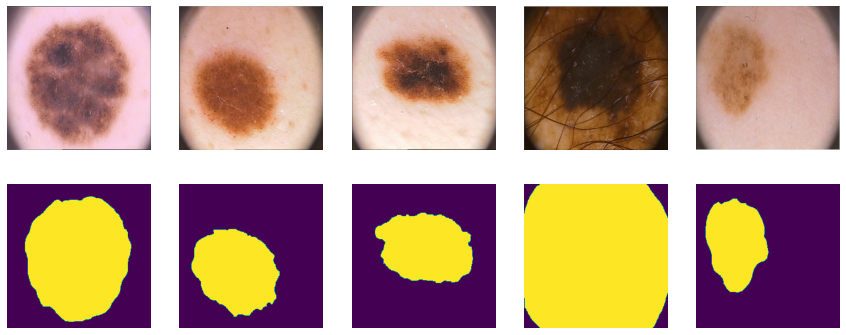

In [58]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18, 6))
i = 0
for X, Y in zip(X_batch, Y_batch):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X.permute(1, 2, 0))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[0])
    i += 1
plt.show()

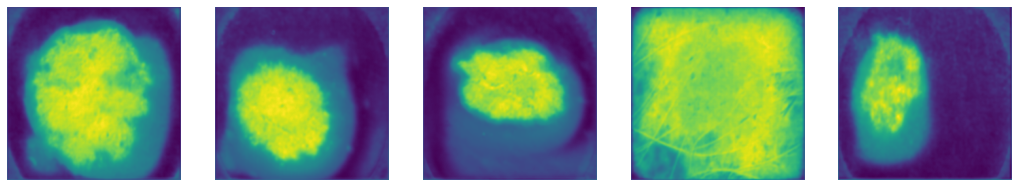

In [65]:
model.eval()
ans = model(X_batch)
i = 0

plt.figure(figsize=(18, 6))

for a in ans:
    plt.subplot(1, 5, i + 1)
    plt.axis("off")
    plt.imshow(a[0].detach().numpy())
    i += 1

In [29]:
X_test, Y_test = next(iter(data_ts))
print (X_test.shape)

torch.Size([5, 3, 256, 256])


Здесь посмотрел как работает модель на тестовой выборке, посчитал точность с который определеятся пиксель 
accuracy = 0.893

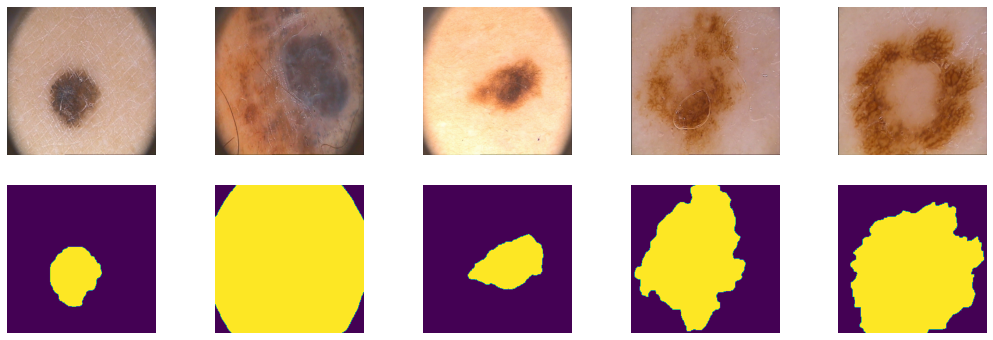

In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize = (18, 6))
i = 0

for X, Y in zip(X_test, Y_test):
    plt.subplot(2, 5, i + 1)
    plt.axis("off")
    plt.imshow(X.permute(1, 2, 0))
    
    plt.subplot(2, 5, i + 6)
    plt.axis("off")
    plt.imshow(Y[0])
    i += 1
    if (i == 6):
        break

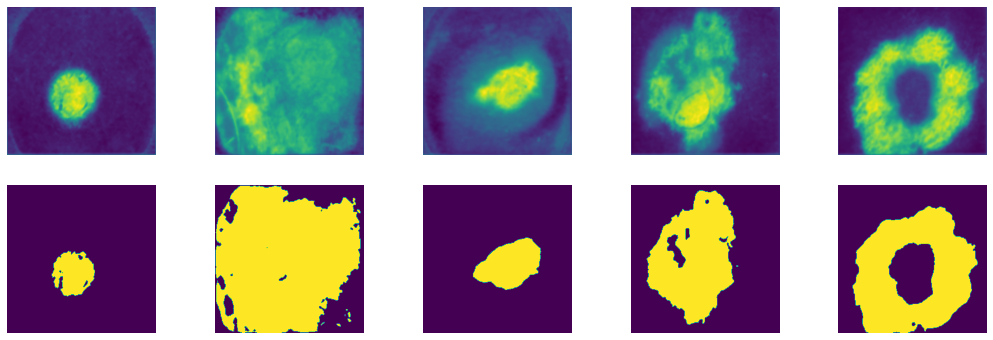

In [31]:
ans_1 = model(X_test)
i = 0

plt.figure(figsize=(18, 6))

for a in ans_1:
    plt.subplot(2, 5, i + 1)
    plt.axis("off")
    plt.imshow(a[0].detach().numpy())
    
    
    plt.subplot(2, 5, i + 6)
    plt.axis("off")
    plt.imshow(((a[0] >= 0.5).to(torch.float32)).detach().numpy())
    
    i += 1
    if (i == 6):
        break

In [34]:
loss = 0
i = 0
for X_ts, Y_ts in data_ts:
    ans = (model(X_ts) >= 0.5).to(torch.float32)
    loss += ((Y_ts == ans).to(torch.float32).sum().item()) / ((ans == ans).to(torch.float32).sum().item())
    i += 1
    
print (loss / i)

0.893145751953125


видно, что есть неточности с центральными светлыми участками(возможно нужно переобучить с аугментацией)